In [114]:
import mne
import numpy as np
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from scipy.io import loadmat

epochs_each = [0] * 5

for j in range(1,6):
    mat_data = loadmat('D:\BCI_competitionIII\BCI_100Hz\S' + str(j) + '_data_set')

    channels = []
    for i in range(0,118):
        channels.append(mat_data['nfo']['clab'][0][0][0][i][0])

    fs = mat_data['nfo']['fs'][0][0][0][0]
    events_index = mat_data['mrk']['pos'][0][0][0]

    events_labels = mat_data['mrk']['y'][0][0][0]
    events_labels= np.nan_to_num(events_labels, nan=0.0)

    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*len(channels),
        sfreq= fs
    )

    info.set_montage('standard_1005', on_missing= 'ignore')
    ev = [i*fs*5 for i in range(len(events_labels))]
    events = np.column_stack((np.array(ev, dtype = int),
                            np.zeros(len(events_labels), dtype = int),
                            np.array(events_labels, dtype = int)))

    cnt = mat_data['cnt'] *0.1
    cnt = cnt.T

    data = []
    for i in range(0,len(events_labels)):
            data.append(cnt[:,events_index[i]:events_index[i] + (fs*5)])

    data = np.asanyarray(data)

    t_min = 0.0
    # t_max = 3.5
    event_id = dict(Right= 1, Foot= 2, no=0)
    epochs_each[j-1] = mne.EpochsArray(data, info, events, t_min, event_id, baseline=None)
    # epochs_each[j-1] = epochs_each[j-1].copy().crop(tmin=0.0, tmax=3.5)
    epochs_each[j-1] = epochs_each[j-1].pick(['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Oz' ,'PO7', 'PO8'])

Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


In [115]:
del cnt
del data
del mat_data

In [116]:
epochs = mne.concatenate_epochs([epochs_each[0], epochs_each[1], epochs_each[2], epochs_each[3], epochs_each[4]])
# epochs = epochs_each[1]

In [117]:
epochs

Number of events,280
Events,Foot: 112Right: 112no: 56
Time range,0.000 – 4.990 s
Baseline,off


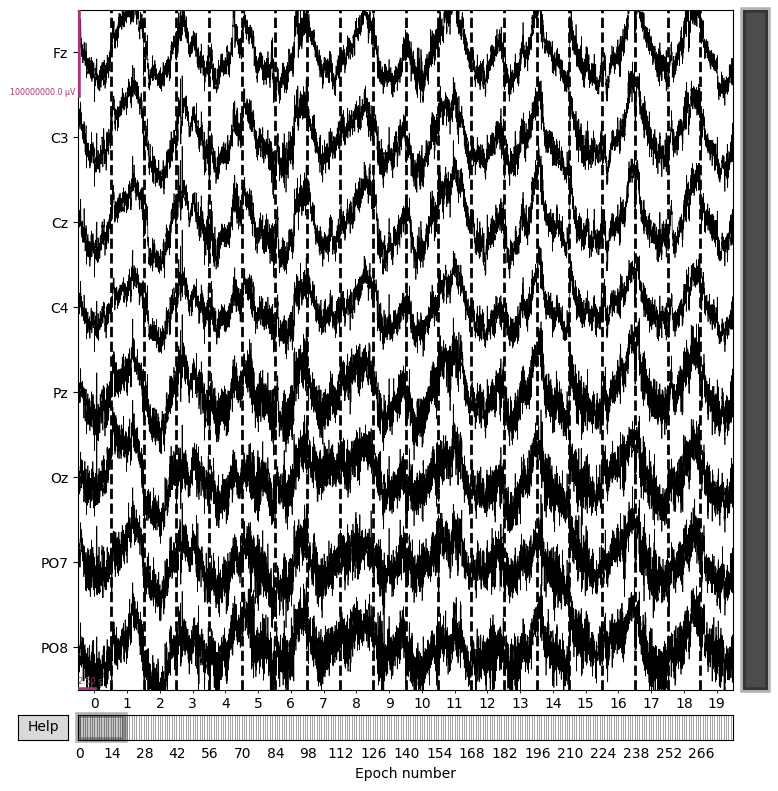

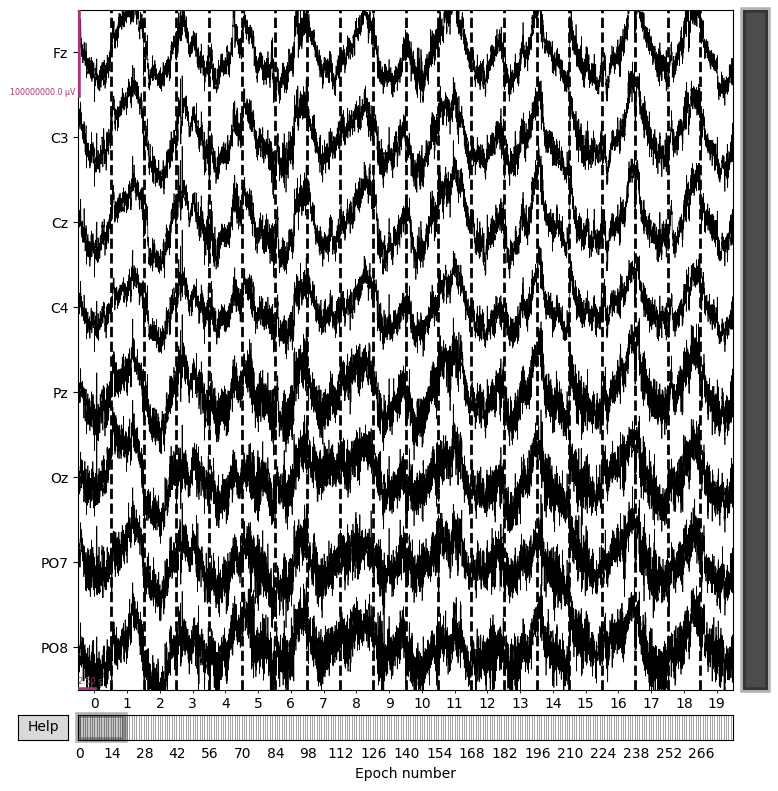

In [118]:
epochs.plot(scalings = 50)

# MRCP & LF-ASD

In [119]:
import sys
import matplotlib.pyplot as plt
eeg1 = epochs.copy().filter(l_freq=0.075, h_freq=3.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")
# eeg1 = eeg1.copy().crop(tmin=0.0, tmax=3.5)

Setting up band-pass filter from 0.075 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 0.07, 3.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


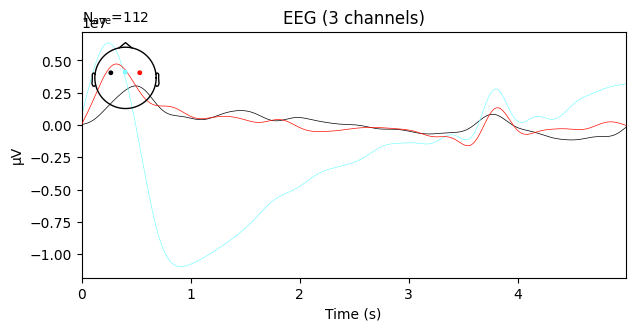

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


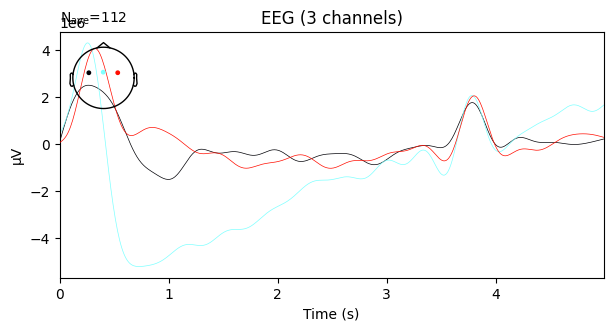

...


In [120]:
eeg1['Foot'].average().pick(['C3','Cz','C4']).plot()
eeg1['Right'].average().pick(['C3','Cz','C4']).plot()
print("...")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


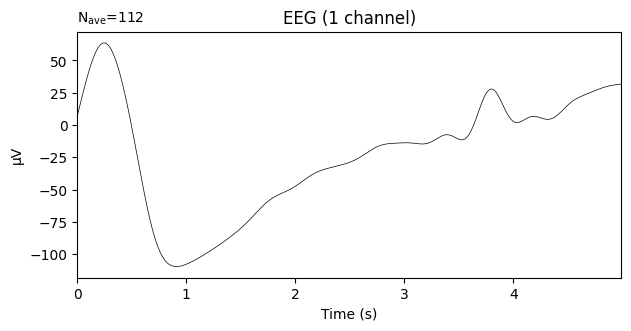

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


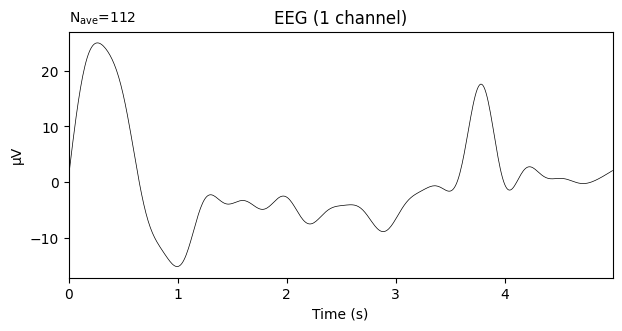

...


In [121]:
eeg1['Foot'].average().plot(scalings=10, picks="Cz")
eeg1['Right'].average().plot(scalings=10, picks="C3")
print('...')

# ERSD

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
eeg2 = epochs.copy().filter(l_freq=8.0, h_freq=30.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg2 = eeg2.copy().pick_channels(['C3','Cz','C4'])
eeg2 = eeg2.copy().set_eeg_reference(ref_channels="average")
# eeg2 = eeg2.copy().crop(tmin=0.0, tmax=3.5)

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [123]:
freqs = np.arange(8, 31)  # frequencies from 8-30Hz
vmin, vmax = -1, 0.5  # set min and max ERDS values in plot
baseline = (0, 2)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

In [124]:
tfr = tfr_multitaper(
    eeg2,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(0, 3.5).apply_baseline(baseline, mode="percent")
event_id2 = dict(Right = 1, Foot = 2)

for event in event_id2:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [125]:
# df = tfr.to_data_frame(time_format=None, long_format=True)

# # Map to frequency bands:
# freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
# df["band"] = pd.cut(
#     df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
# )

# # Filter to retain only relevant frequency bands:
# freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
# df = df[df.band.isin(freq_bands_of_interest)]
# df["band"] = df["band"].cat.remove_unused_categories()

# # Order channels for plotting:
# df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

# g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
# g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
# axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
# g.map(plt.axhline, y=0, **axline_kw)
# g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, vmax))
# g.set_axis_labels("Time (s)", "ERDS")
# g.set_titles(col_template="{col_name}", row_template="{row_name}")
# g.add_legend(ncol=2, loc="lower center")
# g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
# plt.show()

# CSP

In [126]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from mne import Epochs, pick_types, events_from_annotations, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

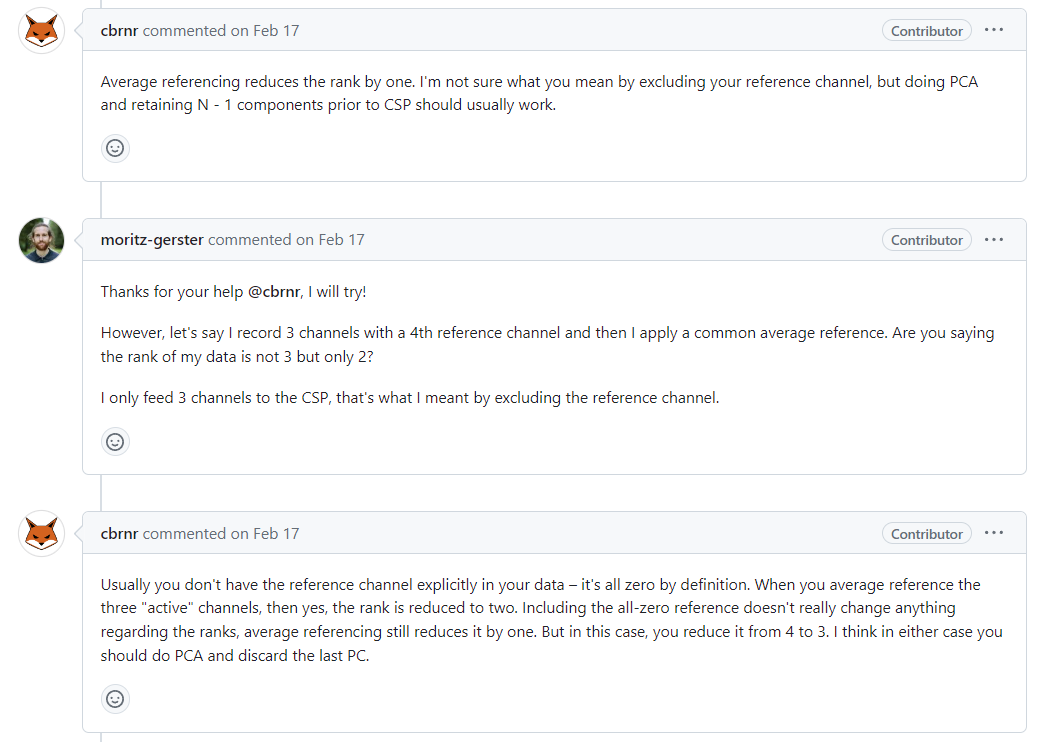

In [127]:
from IPython.display import Image
Image('csp_problem.png')

In [128]:
CSP_epochs = epochs.copy().filter(l_freq=8, h_freq=30.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
# CSP_epochs = CSP_epochs.copy().pick(("Fz","C3", "Cz", "C4","Pz",'PO7','PO8'))
# CSP_epochs = CSP_epochs.copy().set_eeg_reference(ref_channels="average")
CSP_train = CSP_epochs['Right','Foot'].crop(tmin=0.0, tmax=3.5)
labels = CSP_train.events[:, -1]

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



Computing rank from data with rank=None
    Using tolerance 6.1 (2.2e-16 eps * 8 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


    Using tolerance 5.8 (2.2e-16 eps * 8 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2 (2.2e-16 eps * 8 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9 (2.2e-16 eps * 8 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6 (2.2e-16 eps * 8 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels wit

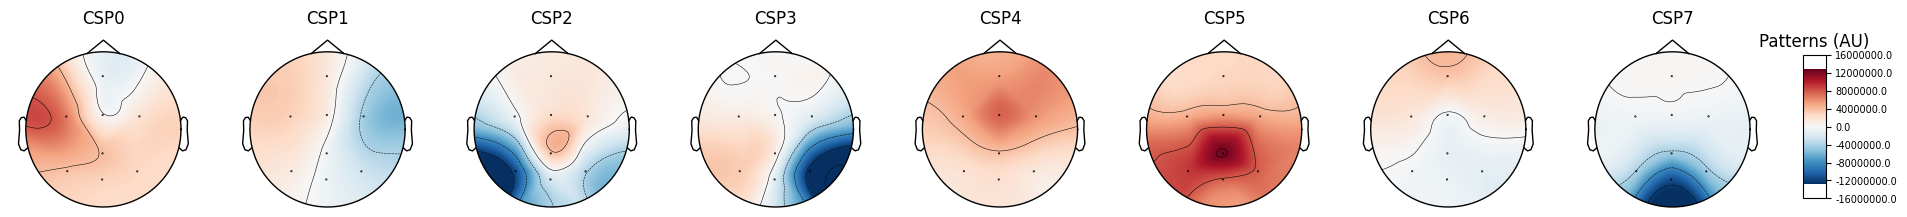

Classification accuracy: 0.924444 / Chance level: 0.500000
[[107   5]
 [ 14  98]]


In [129]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
CSP_epochs_data = CSP_epochs['Right','Foot'].get_data()
CSP_epochs_data_train = CSP_train.get_data()
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(CSP_epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, CSP_epochs_data_train, labels, cv=cv, n_jobs=None)
CSP_predicted = cross_val_predict(clf, CSP_epochs_data_train, labels, cv=5)
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(CSP_epochs_data, labels)

csp.plot_patterns(CSP_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print(conf_matrix)


In [130]:
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt
# from ssqueezepy import ssq_cwt, ssq_stft

# new_data = csp.transform(CSP_epochs_data_train)
# train_size = len(labels)
# train_data_stft = np.ndarray(shape=(train_size, 168,129,2))
# # Parameters for the STFT
# n_fft = 256  # Number of DFT points
# fs = 100
# hop_length = int(n_fft * 0.03)  # 97% overlapping
# win_length = int(n_fft * 0.5)   # 0.5 seconds window length
# window = 'hamming'  # Hamming window

# # Compute the STFT

# for i in range(0,train_size):

#     # D = librosa.stft(new_data[i,:], n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
#     _,D, *_ = ssq_stft(new_data[i,:], n_fft=n_fft, window=window)
#     # print(np.shape(D))
#     # train_data_stft[i, :, :, :] = abs(D)



In [131]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Sample image dimensions
def to_image(coeff):
    width = 37
    height = 8

    # Generate a sample 2D CWT array (replace this with your actual CWT coefficients)
    cwt_coefficients = abs(coeff)

    # Create an empty 3D array for the image (assuming RGB color channels)
    color_channels = 3
    image_3d = np.zeros((width, height, color_channels), dtype=np.uint8)

    # Map the CWT coefficients to color channels for visualization
    # You may need to adjust this mapping based on your specific data
    min_value = np.min(cwt_coefficients)
    max_value = np.max(cwt_coefficients)
    normalized_cwt = (cwt_coefficients - min_value) / (max_value - min_value)

    # Assign the CWT coefficients to the color channels
    image_3d[:, :, 0] = (normalized_cwt * 255).astype(np.uint8)  # Red channel
    image_3d[:, :, 1] = (normalized_cwt * 255).astype(np.uint8)  # Green channel
    image_3d[:, :, 2] = (normalized_cwt * 255).astype(np.uint8)  # Blue channel

    return image_3d

    # Display the 3D image
    # plt.imshow(image_3d)
    # plt.axis('off')
    # plt.title('CWT 3D Image')
    # plt.show()

In [132]:
from ssqueezepy import ssq_cwt, ssq_stft
import pywt
waveletname = 'morl'
new_data = csp.fit_transform(CSP_epochs_data_train, labels)
train_size = len(labels)
train_data_stft = np.ndarray(shape=(train_size, 37,8,3))
# scales = range(1,31)

# coeff, _ = pywt.cwt(new_data[1,:], scales, waveletname, 1)
for i in range(0,train_size):
    _,coeff, *_ = ssq_cwt(new_data[i,:])
    image = to_image(coeff=abs(coeff))
    train_data_stft[i, :, :, :] = image

Computing rank from data with rank=None
    Using tolerance 6.9 (2.2e-16 eps * 8 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6 (2.2e-16 eps * 8 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


In [133]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import History 
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ssqueezepy import ssq_cwt, ssq_stft

In [134]:
x_train, x_test, y_train, y_test = train_test_split(train_data_stft, labels, test_size=0.2, random_state=42)

img_x = 37
img_y = 8
img_z = 3
num_classes = 2

batch_size = 16
epochs = 600
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

# del train_data_cwt
# del combine_epochs
# plt.imshow(x_train[0,:,:,1], aspect='auto', cmap='turbo')
# plt.show()
# plt.imshow(x_train[2,:,:,1], aspect='auto', cmap='turbo')
# plt.show()
y_train = keras.utils.to_categorical(y_train - 1, num_classes)
y_test = keras.utils.to_categorical(y_test -1 , num_classes)
input_shape = (img_x, img_y, img_z)

(179, 37, 8, 3) (45, 37, 8, 3) (179,) (45,)


In [ ]:
shape = np.shape(CSP_train['Right','Foot'].get_data())
array_2d = CSP_train.get_data().reshape(shape[0], shape[1]*shape[2])

scores = cross_val_score(lda, array_2d, labels, cv=cv, n_jobs=None)
CSP_predicted = cross_val_predict(lda, array_2d, labels, cv=5)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print("LDA only classification scores", np.mean(scores))
print(conf_matrix)

LDA only classification scores 0.5535714285714286
[[146 136]
 [132 146]]


Computing rank from data with rank=None
    Using tolerance 3.9 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2 (2.2e-16 eps * 8 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2 (2.2e-16 eps * 8 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG

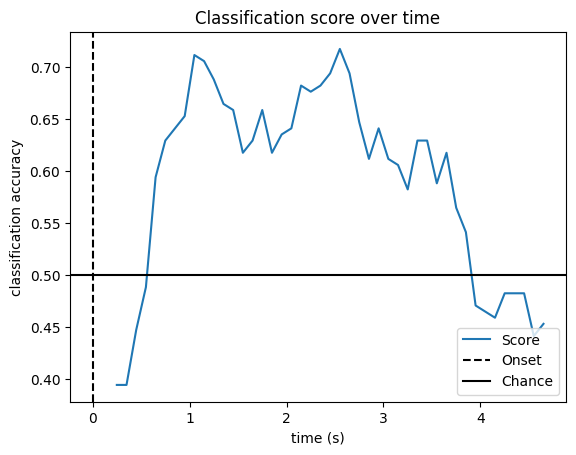

In [ ]:
sfreq = CSP_epochs['Right','Foot'].info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, CSP_epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(CSP_epochs_data_train[train_idx], y_train)
    X_test = csp.transform(CSP_epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(CSP_epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + CSP_epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()


Setting up band-pass filter from 0.1 - 3.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 3.42 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.42 Hz)
- Filter length: 3301 samples (33.010 s)



C:\Users\pipo_\AppData\Local\Temp\ipykernel_9376\549955199.py:29: RuntimeWarning: filter_length (3301) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  CSP_filter = epochs.copy().filter(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 8 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 8 dim * 7.8e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 8 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 8 dim * 8.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.3s finished


Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 8 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 8 dim * 7.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 8 dim * 6.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 8 dim * 8.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 3.9 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4 (2.2e-16 eps * 8 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.1s finished


    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.1 (2.2e-16 eps * 8 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.2s finished


Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2 (2.2e-16 eps * 8 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 8 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.1 (2.2e-16 eps * 8 dim * 2.3e+15  max singula

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 3.6 (2.2e-16 eps * 8 dim * 2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 8 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6 (2.2e-16 eps * 8 dim * 2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 8 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.1s finished


    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6 (2.2e-16 eps * 8 dim * 2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 8 dim * 2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRI

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4 (2.2e-16 eps * 8 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4 (2.2e-16 eps * 8 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.2s finished


    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5 (2.2e-16 eps * 8 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.3s finished


    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.3s finished


    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.6s finished


    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.6e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EM

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.6e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.8e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.8e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: 

[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:    0.2s finished


    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.3e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.8e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.4e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 8 dim * 1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels wit

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


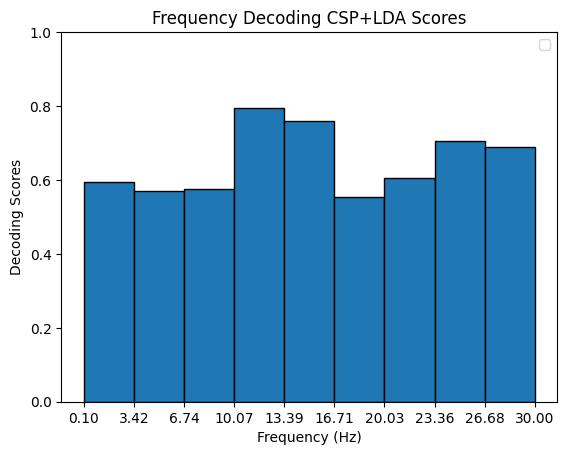

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


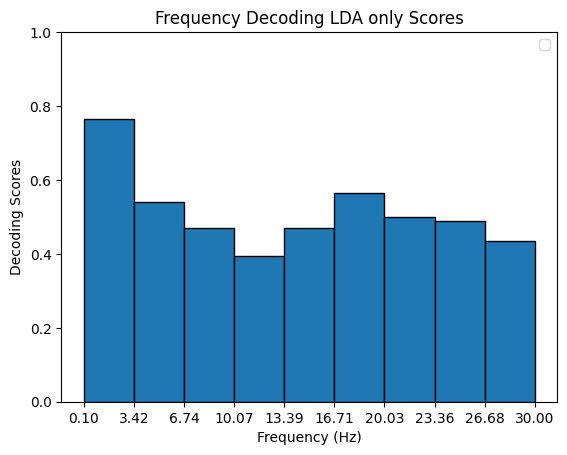

In [ ]:
# Classification & time-frequency parameters
tmin, tmax = 0.000, 3.500
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 0.1
max_freq = 30.0
n_freqs = 10 # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

freq_scores_CSP = np.zeros((n_freqs - 1,))
freq_scores_LDA = np.zeros((n_freqs - 1,))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    CSP_filter = epochs.copy().filter(
        fmin, fmax, fir_design="firwin", skip_by_annotation="edge"
    )

    y = le.fit_transform(CSP_filter['Right','Foot'].events[:, -1])

    X = CSP_filter['Right','Foot'].get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores_CSP[freq] = np.mean(
        cross_val_score(estimator=clf, X=X, y=y, cv=cv), axis=0
    )

    shape = np.shape(CSP_filter['Right','Foot'].get_data())
    X = CSP_filter['Right','Foot'].get_data().reshape(shape[0], shape[1]*shape[2])

    freq_scores_LDA[freq] = np.mean(
        cross_val_score(estimator=lda, X=X, y=y, cv=cv), axis=0
    )
plt.bar(
freqs[:-1], freq_scores_CSP, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding CSP+LDA Scores")
plt.show()

plt.bar(
freqs[:-1], freq_scores_LDA, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding LDA only Scores")
plt.show()

# PSD and Power Plot

In [ ]:
eeg4 = epochs.copy().filter(l_freq=1.0, h_freq=35.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg4 = eeg4.copy().set_eeg_reference(ref_channels="average")
epochs_name = ['Right', 'Foot']
picks = ("C3", "Cz", "C4")
PSD_epochs = eeg4['Right', 'Foot']

Setting up band-pass filter from 1 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 1.00, 35.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


    Using multitaper spectrum estimation with 7 DPSS windows


Averaging across epochs...
...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


No baseline correction applied


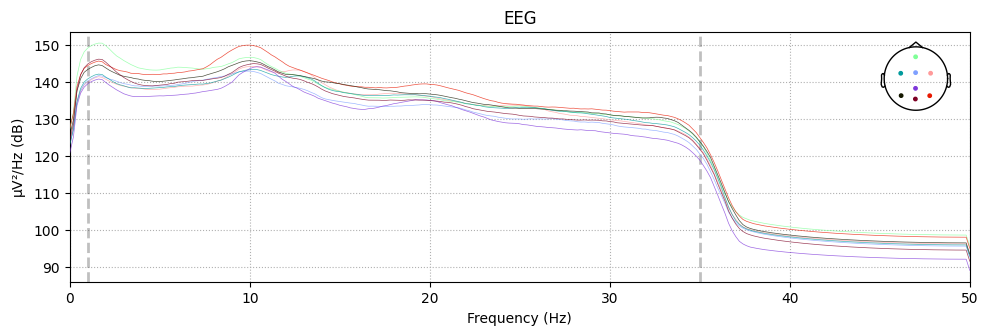

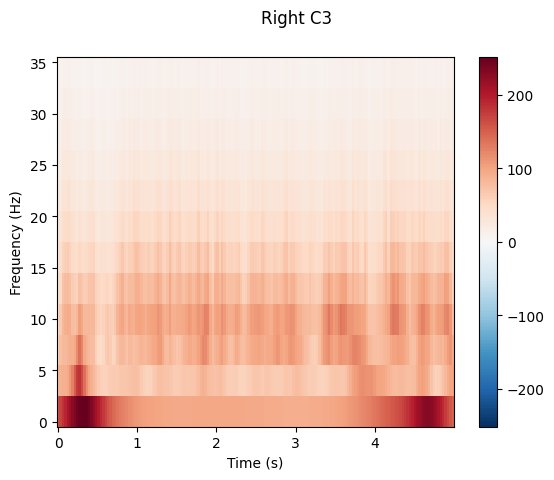

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


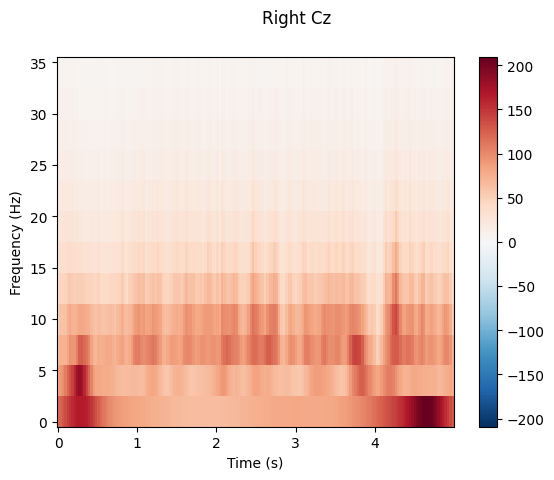

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


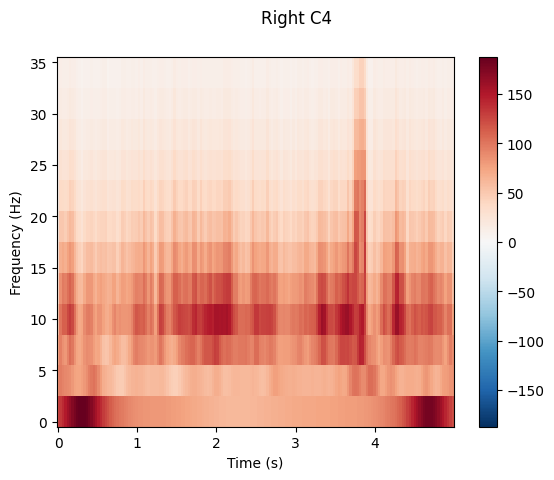

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


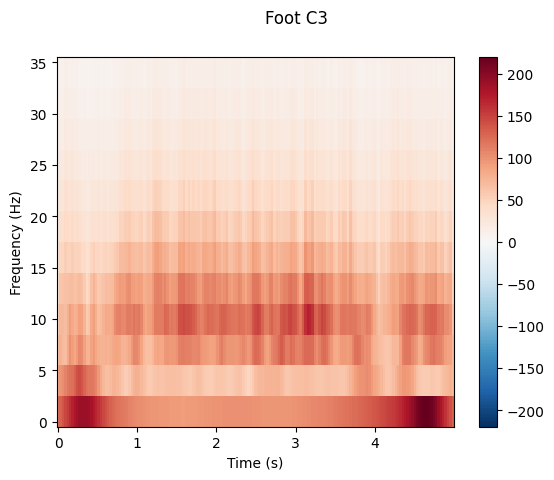

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


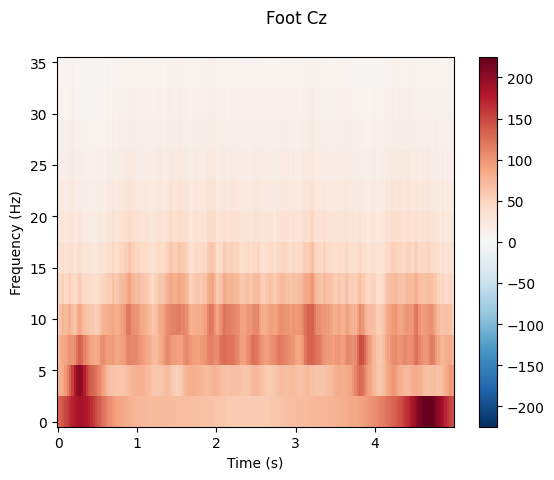

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


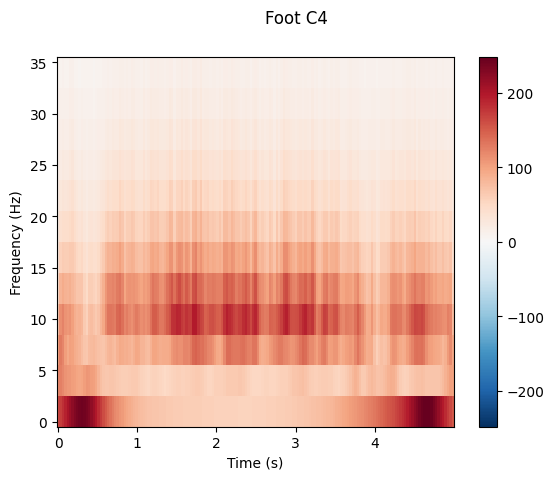

In [ ]:
eeg4.compute_psd(fmax=50).plot(picks="data", exclude="bads")
print("...")
frequencies = np.arange(1, 35, 3)
for i in range(0,2):
    power = mne.time_frequency.tfr_morlet(
        PSD_epochs[epochs_name[i]], n_cycles=2, return_itc=False, freqs=frequencies, decim=3)
    for j in range(0,3):
        power.plot(picks = picks[j], title = str(epochs_name[i]) + " " + str(picks[j]))